In [1]:
DEVICE = 'cuda'

In [2]:
from vit_prisma_legacy.models.base_vit import HookedViT


encoder = HookedViT.from_pretrained("vit_base_patch32_224",
                                        center_writing_weights=True,
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

    

# logits, cache = model.run_with_cache(image.unsqueeze(0))

Official model name vit_base_patch32_224
ln_pre not set
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


In [3]:
import timm

model = timm.create_model('vit_base_patch32_224', pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [64]:
from tqdm import tqdm
def accuracy(output, target, topk=(1, 5)):
    """Computes the accuracy for the top-k predictions and returns the predictions."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        raw_max_logits_values = output.max(dim=1).values
    
        # Get top-k predictions
        topk_preds = output.topk(maxk, dim=1, largest=True, sorted=True).indices

        # Compute top-1 accuracy
        top1_acc = 100.0 * topk_preds[:, 0].eq(target).sum().float() / batch_size

        # Compute top-k accuracy
        correct = topk_preds.eq(target.view(-1, 1))  # Shape: (batch_size, maxk)
        accs = [100.0 * correct[:, :k].float().sum() / batch_size for k in topk]

        return accs, topk_preds[:, 0], topk_preds[:, :5], raw_max_logits_values


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        """Resets all tracked values"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value"""
        self.val = float(val)  # Ensure val is a float
        self.sum += self.val * n
        self.count += n
        self.avg = self.sum / self.count if self.count > 0 else 0  

def average_logit_value_across_all_classes(
    residual_stack,
    cache,
    mean = True,
    ):
    scaled_residual_stack = cache.apply_ln_to_stack(
            residual_stack, layer=-1, pos_slice=0
        )



    all_residual_directions = encoder.tokens_to_residual_directions(np.arange(1000)) # Get all residual directions

    logit_predictions = einsum(
        "layer batch d_model, class d_model -> batch layer class",
        scaled_residual_stack,
        all_residual_directions,
    )
    if mean:
        logit_predictions = logit_predictions.mean(axis=0)

    return logit_predictions

def evaluate_imagenet_probe(encoder, val_loader, probe, layer_hook=None, device='cuda', use_bfloat16=True):

    n_layers = 13
    
       # Create average meters for each layer
    top1_meters = [AverageMeter() for _ in range(n_layers)]
    top5_meters = [AverageMeter() for _ in range(n_layers)]
    
    raw_logits_per_layer = [[] for _ in range(n_layers)]
    count = 0

    MAX = 200
    count = 0

    total_raw_logits = []
    
    with torch.no_grad():
        for i, (images, target) in tqdm(enumerate(val_loader)):

            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=use_bfloat16):

                images = images.to(DEVICE)
                target = target.to(DEVICE)

                # Get representations
                _, cache = encoder.run_with_cache(images)
                # features = cache[layer_hook]
        

                accumulated_residual, layer_labels = cache.accumulated_resid(layer=-1, incl_mid=False, pos_slice=0, return_labels=True)

                
                all_layers_logits = average_logit_value_across_all_classes(
                    accumulated_residual, cache, mean=False
                )

                for layer_idx in range(all_layers_logits.shape[1]):
                    # Get logits for current layer
                    layer_logits = all_layers_logits[:, layer_idx, :]
                    
                    # Calculate accuracy metrics
                    (acc1, acc5), top1_preds, top5_preds, raw_max_logits = accuracy(
                        layer_logits, target, topk=(1, 5)
                    )
                    
                    # # The error suggests that acc1 or acc5 might be AverageMeter objects
                    # acc1 = float(acc1) if not isinstance(acc1, AverageMeter) else acc1.avg
                    # acc5 = float(acc5) if not isinstance(acc5, AverageMeter) else acc5.avg
                    
                    # Update metrics for this layer
                    top1_meters[layer_idx].update(acc1, images.size(0))
                    top5_meters[layer_idx].update(acc5, images.size(0))
                    raw_logits_per_layer[layer_idx].extend(raw_max_logits.cpu().numpy().tolist())
            


            count += 1
            if count > MAX:
                print('cache keys', cache.keys())
                break
                
    return top1_meters, top5_meters, raw_logits_per_layer

In [5]:
from torchvision import datasets, transforms

from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

normalization = ((0.485, 0.456, 0.406),
                     (0.229, 0.224, 0.225))
# Setup data
resolution = 224
transform = transforms.Compose([
            transforms.Resize(size=int(resolution * 256/224)),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(normalization[0], normalization[1])])


data = {}
train_data_path =  "/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/train"
val_data_path = "/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val"
train_data = ImageFolder(root=train_data_path, transform=transform)
val_data = ImageFolder(root=val_data_path, transform=transform)


val_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)


In [63]:
cache

NameError: name 'cache' is not defined

In [29]:
# import torch
# import numpy as np
# from fancy_einsum import einsum

# encoder = encoder.half().to(DEVICE)
# probe = model.head.to(DEVICE).half()

# total_raw_logits = []

# total_top_acc_resid = []
# print("Layers:",  encoder.cfg.n_layers)
# for i in tqdm(range(0, encoder.cfg.n_layers)):
#     top1, top5, raw_logits = evaluate_imagenet_probe(encoder, val_loader, probe, layer_hook=f'blocks.{i}.hook_resid_post', device=DEVICE, use_bfloat16=True)
#     total_top_acc_resid.append((top1, top5))
#     total_raw_logits.append(np.mean(raw_logits))
#     # print(raw_logits)


In [57]:
top1_accs, top5_accs, raw_logits = evaluate_imagenet_probe(
    encoder, val_loader, probe, device=DEVICE, use_bfloat16=True
)

1it [00:00,  3.09it/s]


NameError: name 'ax2' is not defined

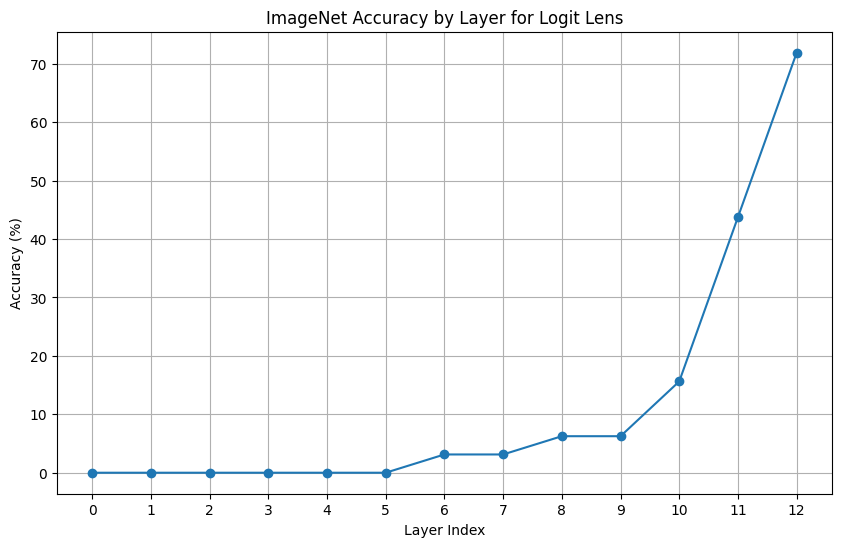

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_by_layer(top1_meters, top5_meters, raw_logits_per_layer=None, title="ImageNet Accuracy by Layer"):
    """
    Plot accuracy metrics by layer based on the AverageMeter objects.
    
    Args:
        top1_meters: List of AverageMeter objects for top-1 accuracy
        top5_meters: List of AverageMeter objects for top-5 accuracy
        raw_logits_per_layer: Optional list of raw logit values by layer
        title: Title for the plot
    """
    n_layers = len(top1_meters)
    layers = range(n_layers)
    
    # Extract average values from AverageMeter objects
    top1_acc = [meter.avg for meter in top1_meters]
    top5_acc = [meter.avg for meter in top5_meters]
    
    # Calculate average raw logits if provided
    if raw_logits_per_layer is not None:
        avg_raw_logits = [np.mean(logits) for logits in raw_logits_per_layer]
    else:
        avg_raw_logits = None
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot accuracy metrics
    plt.plot(layers, top1_acc, marker='o', linestyle='-', color='tab:blue', label='Top-1 Accuracy')
    # plt.plot(layers, top5_acc, marker='s', linestyle='-', color='tab:orange', label='Top-5 Accuracy')
    
    # If raw logits are provided, plot them on a secondary y-axis
    if avg_raw_logits is not None:
        ax2 = plt.gca().twinx()
        ax2.plot(layers, avg_raw_logits, marker='^', linestyle='-', color='tab:red', label='Avg Raw Logits')
        ax2.set_ylabel('Raw Logit Value', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Set up the primary axes
    plt.xlabel('Layer Index')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.xticks(layers)
    plt.grid(True)
    
    # Handle legend
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    if avg_raw_logits is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        plt.legend(lines1 + lines2, labels1 + labels2, loc='best')
    else:
        plt.legend(loc='best')
    
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    import os
    if not os.path.exists("figures"):
        os.makedirs("figures")
    
    # Save plot in both formats
    plt.savefig(f"figures/{title.replace(' ', '_')}.svg")
    plt.savefig(f"figures/{title.replace(' ', '_')}.png", dpi=300)
    
    plt.show()

# Usage example:
# top1_meters, top5_meters, raw_logits_per_layer = evaluate_imagenet_probe(...)
plot_accuracy_by_layer(top1_accs, top5_accs, raw_logits, "ImageNet Accuracy by Layer for Logit Lens")

TypeError: float() argument must be a string or a real number, not 'AverageMeter'

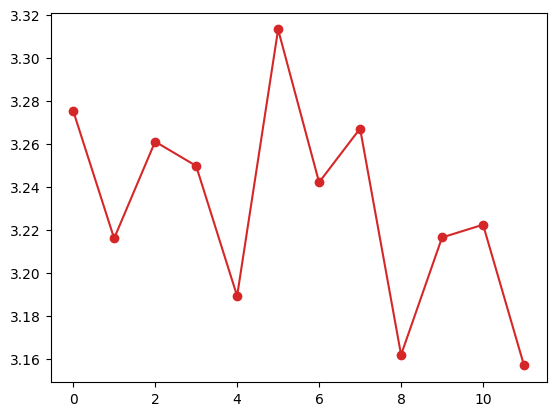

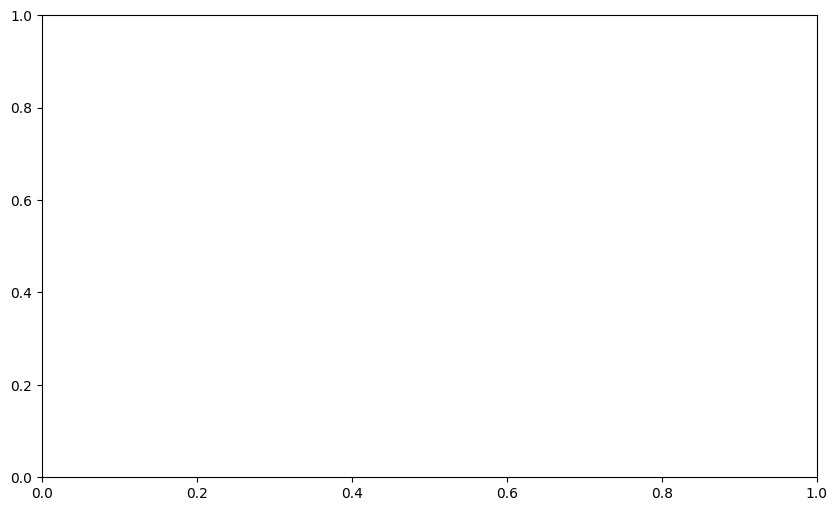

In [23]:
import matplotlib.pyplot as plt

# Assuming total_top_acc_resid is a list of tuples: [(top1, top5), ...]
# For example:
# total_top_acc_resid = [(68.5, 88.0), (70.2, 89.1), ...]

def plot_accuracy_by_layer(total_top_acc_resid, title):
    layers = range(len(total_top_acc_resid))
    top1_acc = [acc[0] for acc in total_top_acc_resid]
    top5_acc = [acc[1] for acc in total_top_acc_resid]

    plt.plot(layers, total_raw_logits, marker='o', linestyle='-', color='tab:red', label='Raw Logits')

    plt.figure(figsize=(10, 6))
    plt.plot(layers, top1_acc, marker='o', linestyle='-', color='tab:blue', label='Top-1 Accuracy')
    # plt.plot(layers, top5_acc, marker='s', linestyle='-', color='tab:orange', label='Top-5 Accuracy')

    plt.xlabel('Layer Index')
    plt.ylabel('Accuracy (%)')
    plt.title('ImageNet Accuracy by Layer')
    plt.xticks(layers)  # Ensures each layer is marked on the x-axis if the number is manageable
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # savep lot as svg
    plt.savefig(f"figures/{title}.svg")
    # png
    plt.savefig(f"figures/{title}.png")
    plt.show()

plot_accuracy_by_layer(total_top_acc_resid, "ImageNet Accuracy by Layer for Logit Lens")